In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import sys
sys.path.insert(0,'../testproblems/tdarcy')
from manufacturedsolutions import *
from NeuralOperator import NeuralOperator

sys.path.insert(0,'../ml')
from quadrature import *
from customlayers import *
from modelloader import loadmodelfromlabel

In [2]:
%load_ext autoreload
%autoreload 2

In [16]:
a = torch.rand((100,100))

In [17]:
eigvals = torch.linalg.eigvals(a)

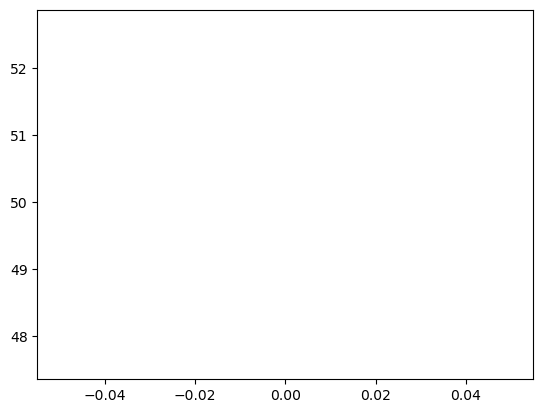

In [15]:
torch.amax(torch.real((eigvals*torch.conj(eigvals))**(1/2)), axis=-1)

tensor([49.9485, 50.0357, 49.6741,  ..., 50.3209, 49.9183, 50.0132])

In [9]:
from NeuralOperator import NeuralOperator

logdir = '../../../nnlogs'
device = 'cuda:1'

sublogdir = 'tdarcy_10x10x10_Nsamples1000'

model = loadmodelfromlabel(model=NeuralOperator, label='dataNGO', logdir=logdir, sublogdir=sublogdir, device=device)
# model.hparams['modeltype'] = 'projection'


In [4]:
# Parameters
N_samples = 1
variables = ['t', 'x', 'x']
l_min = [0.5,0.5,0.5]
l_max = [0.5,0.5,0.5]

dataset = ManufacturedSolutionsSet(N_samples, variables, l_min, l_max, device)

theta = dataset.theta
f = dataset.f
eta_y0 = dataset.etab
eta_yL = dataset.etat
g_x0 = dataset.gl
g_xL = dataset.gr
u = dataset.u
u0 = dataset.u0

0


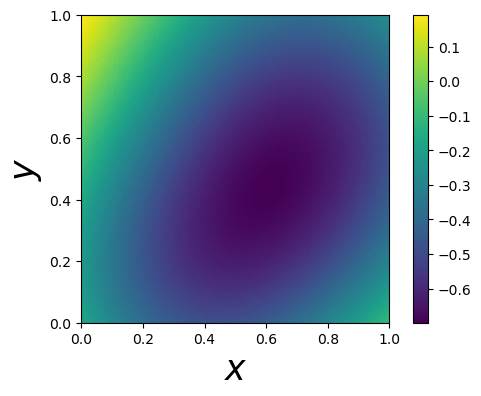

In [5]:
# Create grid
X, Y = np.mgrid[0:1:100*1j, 0:1:100*1j]
x = np.vstack([X.ravel(), Y.ravel()]).T
x = torch.tensor(x)
tx = torch.zeros((x.shape[0], x.shape[1] + 1), device=device)
tx[:, 1:] = x
t = 0
tx[:, 0] = t
u_true = discretize_functions(u, tx, dtype=model.hparams['dtype'], device=device)

size_title = 20
size_ticklabels = 15
size_axeslabels = 25

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

# fig = ax.tripcolor(tx[:,1], tx[:,2], variable_d[0])
fig = ax.tripcolor(tx[:,1].detach().cpu().numpy(), tx[:,2].detach().cpu().numpy(), u_true[0].detach().cpu().numpy())

ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.colorbar(fig)

plt.show()

In [ ]:
variable = dataset.u

# Create grid
T, X, Y = np.mgrid[0:1:10j, 0:1:100*1j, 0:1:100*1j]
x = np.vstack([T.ravel(), X.ravel(), Y.ravel()]).T
x = torch.tensor(x, dtype=model.hparams['dtype'], device=device)
u_true = discretize_functions(u, x, dtype=model.hparams['dtype'], device=device).reshape((11,101,101)).detach().cpu().numpy()
u_hat = model.simforward(theta, f, eta_y0, eta_yL, g_x0, g_xL, u0, tx, u).reshape((11,101,101)).detach().cpu().numpy()
print(u_true.shape)

size_title = 20
size_ticklabels = 15
size_axeslabels = 25

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

fig = ax.tripcolor(tx[:,1].detach().cpu().numpy(), tx[:,2].detach().cpu().numpy(), variable_d[0].detach().cpu().numpy())

ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.colorbar(fig)

plt.show()

# Animation parameters
size_title = 20
size_ticklabels = 15
size_axeslabels = 25
t_values = np.linspace(0, 1, 11)  # Time steps for the animation

# Initialize figure and axis
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

# Set up the plot
tripcolor_plot = ax.tripcolor(x[:, 0].numpy(), x[:, 1].numpy(), np.zeros_like(x[:, 0].numpy()), vmin=torch.amin(variable_d), vmax=torch.amax(variable_d))

ax.ticklabel_format(style='sci', scilimits=[-3, 3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect('equal')
cbar = plt.colorbar(tripcolor_plot, ax=ax)

# Update function for the animation
def update(t):
    print(t)
    tx = torch.zeros(x.shape[0], x.shape[1] + 1, device=device)
    tx[:, 1:] = x
    tx[:, 0] = t
    u_true = discretize_functions(variable, tx, dtype=model.hparams['dtype'], device='cuda:3').detach().cpu().numpy()
    u_hat = model.simforward(theta, f, eta_y0, eta_yL, g_x0, g_xL, u0, tx, u).detach().cpu().numpy()
    

    # tripcolor_plot.set_array(u_d[0].numpy())
    tripcolor_plot = ax.tripcolor(x[:, 0].detach().cpu().numpy(), x[:, 1].detach().cpu().numpy(), u_hat[0] - u_true[0])
    ax.set_title(f'Time: {t:.2f}', fontsize=size_title)

# Create the animation
ani = FuncAnimation(fig, update, frames=t_values, repeat=False)

# Save or display animation
ani.save('diff.gif', writer='pillow', fps=5)
# plt.show()  # Uncomment to display the animation


0


RuntimeError: shape '[11, 101, 101]' is invalid for input of size 100000

: 